In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import VAR

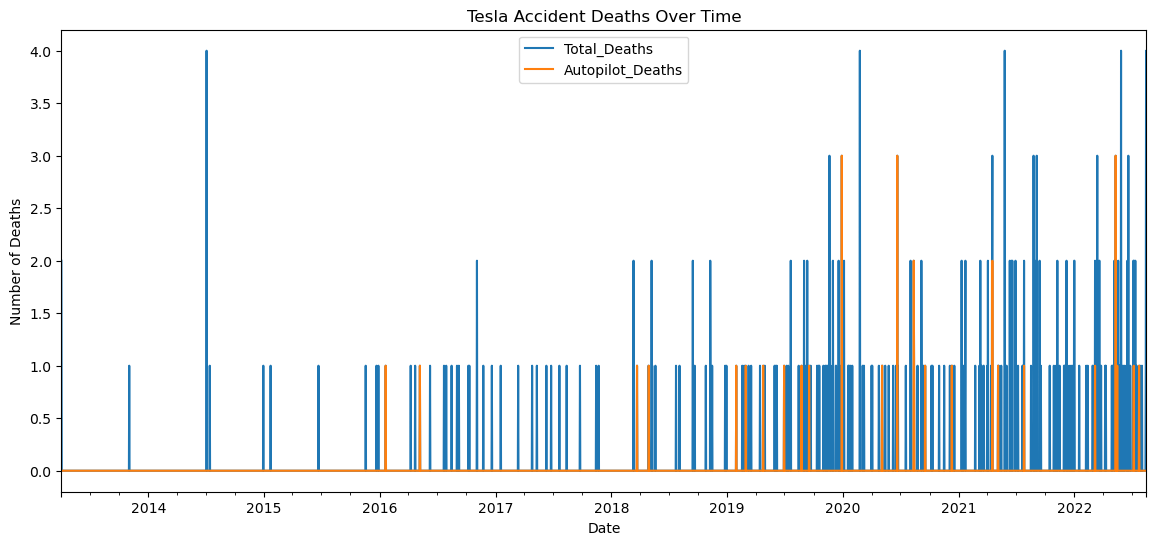

In [14]:
df = pd.read_csv('Tesla Deaths - Deaths (3).csv')

df.columns = df.columns.str.strip()

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')

df['Autopilot_Claimed'] = df['AutoPilot claimed'].apply(lambda x: 1 if str(x).strip() not in ['-', 'nan', ''] else 0)

df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce').fillna(0)

daily_total = df.groupby('Date')['Deaths'].sum()
daily_auto = df[df['Autopilot_Claimed'] == 1].groupby('Date')['Deaths'].sum()

df_grouped = pd.concat([daily_total, daily_auto], axis=1)
df_grouped.columns = ['Total_Deaths', 'Autopilot_Deaths']
df_grouped = df_grouped.asfreq('D').fillna(0)

df_grouped.plot(figsize=(14,6), title='Tesla Accident Deaths Over Time')
plt.ylabel("Number of Deaths")
plt.show()

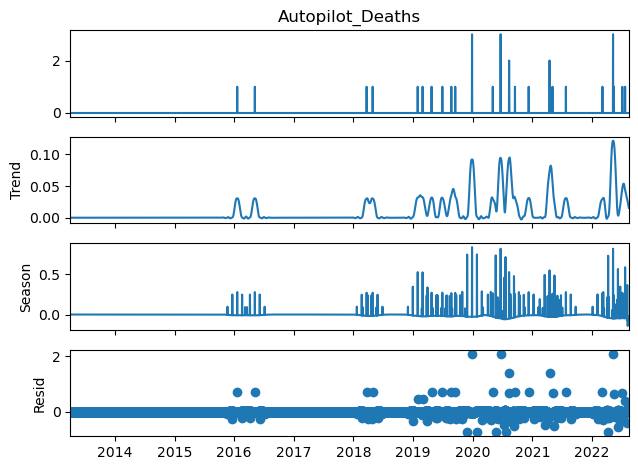

In [16]:
stl = STL(df_grouped['Autopilot_Deaths'], period=30)
res = stl.fit()
res.plot()
plt.show()

In [20]:
model = VAR(df_grouped)
results = model.fit(maxlags=15, ic='aic')

print(results.summary())

forecast_input = df_grouped.values[-results.k_ar:]
forecast = results.forecast(y=forecast_input, steps=7)

forecast_df = pd.DataFrame(forecast,
                           index=pd.date_range(start=df_grouped.index[-1] + pd.Timedelta(days=1), periods=7),
                           columns=df_grouped.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Apr, 2025
Time:                     22:20:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.18029
Nobs:                     3411.00    HQIC:                  -6.24271
Log likelihood:           1080.13    FPE:                 0.00187826
AIC:                     -6.27741    Det(Omega_mle):      0.00184887
--------------------------------------------------------------------
Results for equation Total_Deaths
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.046337         0.007463            6.209           0.000
L1.Total_Deaths              0.068362         0.018335            3.728           0.000
L1.Autopilot_Deaths      

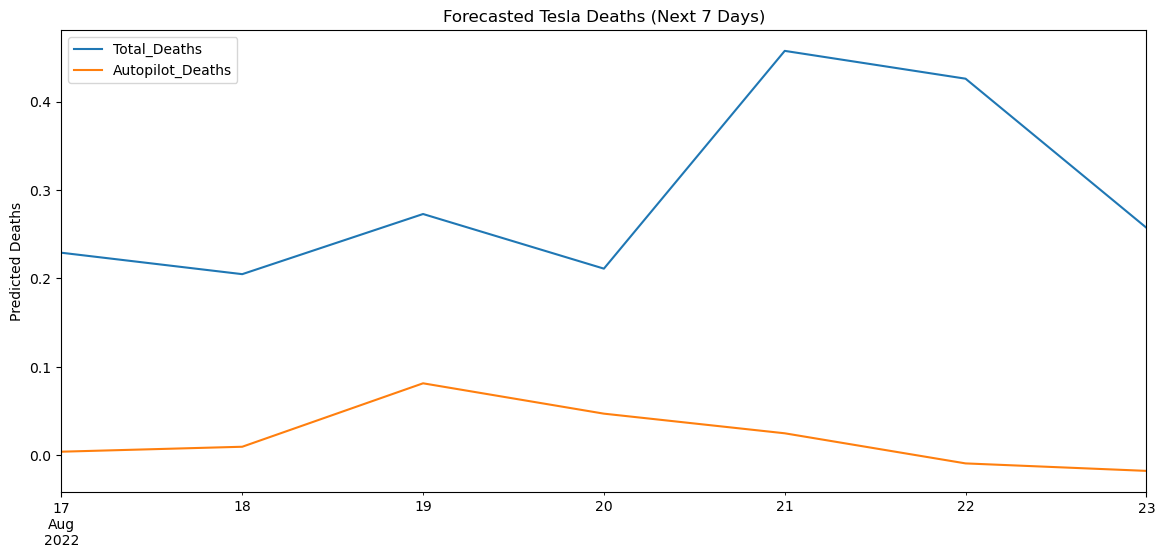

In [22]:
forecast_df.plot(figsize=(14,6), title='Forecasted Tesla Deaths (Next 7 Days)')
plt.ylabel("Predicted Deaths")
plt.show()